## 1. Imports et Configuration

In [12]:
# Imports standards
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from datetime import datetime
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning - Modèles
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Machine Learning - Optimisation
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import randint, uniform

# Machine Learning - Évaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Configuration des graphiques
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Tous les packages importés avec succès!")
print(f"📅 Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Tous les packages importés avec succès!
📅 Date d'exécution: 2025-12-25 13:02:27


## 2. Chargement des Données Preprocessées

In [14]:
import os
import pickle
import pandas as pd
from collections import Counter

# Définir le chemin vers les processeurs
PROCESSOR_DIR = 'processors'

def load_preprocessed_data(processor_dir=PROCESSOR_DIR):
    """
    Charge les données preprocessées et les processeurs
    (compatible multi-classes)
    """
    print("="*80)
    print("CHARGEMENT DES DONNÉES PREPROCESSÉES")
    print("="*80)
    
    # --------------------------
    # 1️⃣ Charger les données
    # --------------------------
    data_path = os.path.join(processor_dir, 'preprocessed_data.pkl')
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    print(f"✅ Données chargées:")
    print(f"   • X_train: {X_train.shape}")
    print(f"   • X_test:  {X_test.shape}")
    print(f"   • y_train: {y_train.shape}")
    print(f"   • y_test:  {y_test.shape}")
    
    # --------------------------
    # 2️⃣ Charger les processeurs
    # --------------------------
    processors = {}
    processor_files = [
        'scaler.pkl',
        'label_encoders.pkl',
        'feature_names.pkl',
        'smote_config.pkl'
    ]
    
    print(f"\n✅ Processeurs chargés:")
    for filename in processor_files:
        filepath = os.path.join(processor_dir, filename)
        if os.path.exists(filepath):
            with open(filepath, 'rb') as f:
                processors[filename.replace('.pkl', '')] = pickle.load(f)
            print(f"   • {filename}")
    
    # --------------------------
    # 3️⃣ Statistiques des classes (MULTI-CLASSES)
    # --------------------------
    print(f"\n📊 Distribution des classes (TRAIN):")
    train_dist = Counter(y_train)
    total_train = len(y_train)
    
    for cls, count in sorted(train_dist.items()):
        print(f"   • Classe {cls}: {count:,} ({count/total_train*100:.2f}%)")
    
    print(f"\n📊 Distribution des classes (TEST):")
    test_dist = Counter(y_test)
    total_test = len(y_test)
    
    for cls, count in sorted(test_dist.items()):
        print(f"   • Classe {cls}: {count:,} ({count/total_test*100:.2f}%)")
    
    return X_train, X_test, y_train, y_test, processors


# --------------------------
# Charger les données
# --------------------------
X_train, X_test, y_train, y_test, processors = load_preprocessed_data()


CHARGEMENT DES DONNÉES PREPROCESSÉES
✅ Données chargées:
   • X_train: (602028, 20)
   • X_test:  (60000, 20)
   • y_train: (602028,)
   • y_test:  (60000,)

✅ Processeurs chargés:
   • scaler.pkl
   • label_encoders.pkl
   • feature_names.pkl
   • smote_config.pkl

📊 Distribution des classes (TRAIN):
   • Classe 1: 150,507 (25.00%)
   • Classe 2: 150,507 (25.00%)
   • Classe 3: 150,507 (25.00%)
   • Classe 4: 150,507 (25.00%)

📊 Distribution des classes (TEST):
   • Classe 1: 45 (0.07%)
   • Classe 2: 37,627 (62.71%)
   • Classe 3: 22,295 (37.16%)
   • Classe 4: 33 (0.06%)


## 3. Phase 1: Modèles de Base (Baseline)

In [16]:
def get_baseline_models():
    """
    Définit les modèles de base avec hyperparamètres par défaut
    """
    models = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            min_samples_split=10,
            min_samples_leaf=4,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        
        'XGBoost': XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            scale_pos_weight=1,
            eval_metric='logloss',
            use_label_encoder=False
        ),
        
        'LightGBM': LGBMClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            num_leaves=31,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1,
            verbose=-1
        ),
        
        'CatBoost': CatBoostClassifier(
            iterations=100,
            depth=6,
            learning_rate=0.1,
            random_state=42,
            auto_class_weights='Balanced',
            verbose=False
        )
    }
    
    print(f"{'='*80}")
    print("MODÈLES BASELINE CONFIGURÉS")
    print(f"{'='*80}")
    for i, name in enumerate(models.keys(), 1):
        print(f"{i}. {name}")
    
    return models

# Définir les modèles de base
baseline_models = get_baseline_models()

MODÈLES BASELINE CONFIGURÉS
1. Random Forest
2. XGBoost
3. LightGBM
4. CatBoost


## 4. Entraînement des Modèles Baseline

In [18]:
from sklearn.preprocessing import LabelEncoder

# =====================================================================================
# 1️⃣ ENCODAGE DE LA TARGET (MULTICLASS OBLIGATOIRE POUR XGBOOST)
# =====================================================================================
print("="*80)
print("ENCODAGE DE LA VARIABLE CIBLE")
print("="*80)

label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

print("Classes originales :", np.unique(y_train))
print("Classes encodées    :", np.unique(y_train_enc))

ENCODAGE DE LA VARIABLE CIBLE
Classes originales : [1 2 3 4]
Classes encodées    : [0 1 2 3]


In [22]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import numpy as np
import time

def train_and_evaluate_models(models, X_train, y_train_enc, X_test, y_test_enc, model_type="Baseline"):
    """
    Entraîne et évalue tous les modèles (binaire ou multiclass)
    """
    print(f"\n{'='*80}")
    print(f"ENTRAÎNEMENT ET ÉVALUATION - {model_type}")
    print(f"{'='*80}\n")

    results = {}

    # Détection automatique du type de classification
    n_classes = len(np.unique(y_train_enc))
    is_binary = n_classes == 2

    average_type = "binary" if is_binary else "weighted"

    for name, model in models.items():
        print(f"🔄 {name}...")
        start_time = time.time()

        # Entraînement
        model.fit(X_train, y_train_enc)
        training_time = time.time() - start_time

        # Prédictions
        y_pred = model.predict(X_test)

        # Probabilités si disponibles
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)
        else:
            y_pred_proba = None

        # Métriques principales
        accuracy = accuracy_score(y_test_enc, y_pred)
        precision = precision_score(y_test_enc, y_pred, average=average_type, zero_division=0)
        recall = recall_score(y_test_enc, y_pred, average=average_type, zero_division=0)
        f1 = f1_score(y_test_enc, y_pred, average=average_type, zero_division=0)

        # ROC-AUC (adapté)
        if y_pred_proba is not None:
            try:
                if is_binary:
                    roc_auc = roc_auc_score(y_test_enc, y_pred_proba[:, 1])
                else:
                    roc_auc = roc_auc_score(
                        y_test_enc,
                        y_pred_proba,
                        multi_class="ovr",
                        average="weighted"
                    )
            except ValueError:
                roc_auc = None
        else:
            roc_auc = None

        results[name] = {
            "model": model,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "roc_auc": roc_auc,
            "training_time": training_time,
            "y_pred": y_pred,
            "y_pred_proba": y_pred_proba
        }

        if roc_auc is not None:
            print(f"   ✅ Accuracy: {accuracy:.4f} | ROC-AUC: {roc_auc:.4f} | Temps: {training_time:.2f}s\n")
        else:
            print(f"   ✅ Accuracy: {accuracy:.4f} | Temps: {training_time:.2f}s\n")

    return results
    
# Entraîner les modèles baseline
baseline_results = train_and_evaluate_models(
    baseline_models, X_train, y_train_enc, X_test, y_test_enc, "Baseline"
)


ENTRAÎNEMENT ET ÉVALUATION - Baseline

🔄 Random Forest...
   ✅ Accuracy: 0.9106 | ROC-AUC: 0.9607 | Temps: 52.67s

🔄 XGBoost...
   ✅ Accuracy: 0.8582 | ROC-AUC: 0.9255 | Temps: 16.39s

🔄 LightGBM...
   ✅ Accuracy: 0.8672 | ROC-AUC: 0.9316 | Temps: 8.45s

🔄 CatBoost...
   ✅ Accuracy: 0.8143 | ROC-AUC: 0.8843 | Temps: 18.42s



## 5. Phase 2: Fine-Tuning avec RandomizedSearchCV

### 5.1 Définition des Hyperparamètres à Tester

In [24]:
def get_param_distributions():
    """
    Définit les distributions de paramètres pour RandomizedSearchCV
    """
    param_distributions = {
        'Random Forest': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [10, 20, 30, 40, None],
            'min_samples_split': [2, 5, 10, 15],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', None],
            'class_weight': ['balanced', 'balanced_subsample']
        },
        
        'XGBoost': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [3, 5, 7, 9],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3],
            'min_child_weight': [1, 3, 5, 7]
        },
        
        'LightGBM': {
            'n_estimators': [100, 200, 300, 400],
            'max_depth': [3, 5, 7, 9, -1],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'num_leaves': [15, 31, 63, 127],
            'min_child_samples': [10, 20, 30, 50],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
        },
        
        'CatBoost': {
            'iterations': [100, 200, 300, 400],
            'depth': [4, 6, 8, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'border_count': [32, 64, 128, 254]
        }
    }
    
    return param_distributions

param_distributions = get_param_distributions()

print(f"{'='*80}")
print("PARAMÈTRES DE RECHERCHE DÉFINIS")
print(f"{'='*80}")
for model_name, params in param_distributions.items():
    print(f"\n{model_name}: {len(params)} hyperparamètres à optimiser")
    for param_name in params.keys():
        print(f"  • {param_name}")

PARAMÈTRES DE RECHERCHE DÉFINIS

Random Forest: 6 hyperparamètres à optimiser
  • n_estimators
  • max_depth
  • min_samples_split
  • min_samples_leaf
  • max_features
  • class_weight

XGBoost: 7 hyperparamètres à optimiser
  • n_estimators
  • max_depth
  • learning_rate
  • subsample
  • colsample_bytree
  • gamma
  • min_child_weight

LightGBM: 7 hyperparamètres à optimiser
  • n_estimators
  • max_depth
  • learning_rate
  • num_leaves
  • min_child_samples
  • subsample
  • colsample_bytree

CatBoost: 5 hyperparamètres à optimiser
  • iterations
  • depth
  • learning_rate
  • l2_leaf_reg
  • border_count


### 5.2 Exécution du Fine-Tuning

In [26]:
def fine_tune_models(baseline_models, param_distributions, X_train, y_train_enc, n_iter=5, cv=3):
    """
    Fine-tune tous les modèles avec RandomizedSearchCV
    
    Parameters:
    -----------
    baseline_models : dict
        Modèles de base
    param_distributions : dict
        Distributions de paramètres pour chaque modèle
    X_train, y_train_enc : array-like
        Données d'entraînement
    n_iter : int
        Nombre d'itérations pour RandomizedSearchCV
    cv : int
        Nombre de folds pour la cross-validation
    
    Returns:
    --------
    dict : Modèles optimisés et leurs meilleurs paramètres
    """
    print(f"\n{'='*80}")
    print(f"FINE-TUNING DES MODÈLES")
    print(f"{'='*80}")
    print(f"Configuration: {n_iter} itérations × {cv}-fold CV")
    print(f"Métrique d'optimisation: ROC-AUC\n")
    
    tuned_models = {}
    best_params_dict = {}
    
    for name, base_model in baseline_models.items():
        print(f"\n{'─'*80}")
        print(f"🔧 Fine-tuning: {name}")
        print(f"{'─'*80}")
        
        start_time = time.time()
        
        # RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_distributions[name],
            n_iter=n_iter,
            cv=cv,
            scoring='roc_auc_ovr',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        random_search.fit(X_train, y_train_enc)
        
        tuning_time = time.time() - start_time
        
        tuned_models[name] = random_search.best_estimator_
        best_params_dict[name] = random_search.best_params_
        
        print(f"\n✅ Terminé en {tuning_time:.2f}s")
        print(f"   • Meilleur score CV: {random_search.best_score_:.4f}")
        print(f"   • Meilleurs paramètres:")
        for param, value in random_search.best_params_.items():
            print(f"     - {param}: {value}")
    
    print(f"\n{'='*80}")
    print("✅ FINE-TUNING TERMINÉ POUR TOUS LES MODÈLES")
    print(f"{'='*80}")
    
    return tuned_models, best_params_dict

# Exécuter le fine-tuning (peut prendre quelques minutes)
print("⏳ Fine-tuning en cours... Cela peut prendre plusieurs minutes...")
tuned_models, best_params = fine_tune_models(
    baseline_models,
    param_distributions,
    X_train,
    y_train_enc,
    n_iter=5,  # Augmenter à 50+ pour meilleurs résultats
    cv=3        # Augmenter à 5 pour validation plus robuste
)

⏳ Fine-tuning en cours... Cela peut prendre plusieurs minutes...

FINE-TUNING DES MODÈLES
Configuration: 5 itérations × 3-fold CV
Métrique d'optimisation: ROC-AUC


────────────────────────────────────────────────────────────────────────────────
🔧 Fine-tuning: Random Forest
────────────────────────────────────────────────────────────────────────────────

✅ Terminé en 3525.26s
   • Meilleur score CV: 0.9949
   • Meilleurs paramètres:
     - n_estimators: 100
     - min_samples_split: 15
     - min_samples_leaf: 2
     - max_features: log2
     - max_depth: None
     - class_weight: balanced

────────────────────────────────────────────────────────────────────────────────
🔧 Fine-tuning: XGBoost
────────────────────────────────────────────────────────────────────────────────

✅ Terminé en 593.03s
   • Meilleur score CV: 0.9950
   • Meilleurs paramètres:
     - subsample: 0.6
     - n_estimators: 400
     - min_child_weight: 5
     - max_depth: 5
     - learning_rate: 0.2
     - gamma: 0
 

### 5.3 Évaluation des Modèles Fine-Tunés

In [28]:
# Évaluer les modèles fine-tunés
tuned_results = train_and_evaluate_models(
    tuned_models, X_train, y_train_enc, X_test, y_test_enc, "Fine-Tuned"
)


ENTRAÎNEMENT ET ÉVALUATION - Fine-Tuned

🔄 Random Forest...
   ✅ Accuracy: 0.9161 | ROC-AUC: 0.9645 | Temps: 56.30s

🔄 XGBoost...
   ✅ Accuracy: 0.9121 | ROC-AUC: 0.9634 | Temps: 58.44s

🔄 LightGBM...
   ✅ Accuracy: 0.9230 | ROC-AUC: 0.9693 | Temps: 33.58s

🔄 CatBoost...
   ✅ Accuracy: 0.8849 | ROC-AUC: 0.9431 | Temps: 56.29s



## 6. Phase 3: Ensemble Learning - Stacking

### 6.1 Stacking avec Logistic Regression comme Meta-Learner

In [30]:
def create_stacking_ensemble(tuned_models, X_train, y_train_enc):
    """
    Crée un ensemble stacking avec les modèles fine-tunés
    
    Returns:
    --------
    dict : Modèles stacking et voting
    """
    print(f"\n{'='*80}")
    print("CRÉATION DES ENSEMBLES - STACKING & VOTING")
    print(f"{'='*80}\n")
    
    # Préparer les estimateurs pour stacking
    estimators = [(name, model) for name, model in tuned_models.items()]
    
    # 1. Stacking Classifier avec Logistic Regression
    print("🔨 Création du Stacking Classifier...")
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight='balanced'
        ),
        cv=5,
        n_jobs=-1
    )
    
    print("   Base learners:")
    for name in tuned_models.keys():
        print(f"     • {name}")
    print(f"   Meta-learner: Logistic Regression")
    
    # 2. Voting Classifier (Soft Voting)
    print("\n🔨 Création du Voting Classifier (Soft)...")
    voting_clf = VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=-1
    )
    
    ensemble_models = {
        'Stacking': stacking_clf,
        'Voting (Soft)': voting_clf
    }
    
    print(f"\n✅ Ensembles créés avec succès!")
    
    return ensemble_models

# Créer les ensembles
ensemble_models = create_stacking_ensemble(tuned_models, X_train, y_train_enc)


CRÉATION DES ENSEMBLES - STACKING & VOTING

🔨 Création du Stacking Classifier...
   Base learners:
     • Random Forest
     • XGBoost
     • LightGBM
     • CatBoost
   Meta-learner: Logistic Regression

🔨 Création du Voting Classifier (Soft)...

✅ Ensembles créés avec succès!


### 6.2 Entraînement et Évaluation des Ensembles

In [32]:
# Entraîner et évaluer les ensembles
ensemble_results = train_and_evaluate_models(
    ensemble_models, X_train, y_train_enc, X_test, y_test_enc, "Ensemble"
)


ENTRAÎNEMENT ET ÉVALUATION - Ensemble

🔄 Stacking...
   ✅ Accuracy: 0.9295 | ROC-AUC: 0.9703 | Temps: 1212.00s

🔄 Voting (Soft)...
   ✅ Accuracy: 0.9166 | ROC-AUC: 0.9654 | Temps: 325.55s



## 7. Comparaison Complète - Tous les Modèles

In [35]:
def create_comprehensive_comparison(baseline_results, tuned_results, ensemble_results):
    """
    Crée un tableau comparatif complet de tous les modèles
    """
    comparison_data = []
    
    # Baseline models
    for name, metrics in baseline_results.items():
        comparison_data.append({
            'Modèle': f"{name} (Baseline)",
            'Type': 'Baseline',
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1_score'],
            'ROC-AUC': metrics['roc_auc'],
            'Temps (s)': metrics['training_time']
        })
    
    # Tuned models
    for name, metrics in tuned_results.items():
        comparison_data.append({
            'Modèle': f"{name} (Tuned)",
            'Type': 'Fine-Tuned',
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1_score'],
            'ROC-AUC': metrics['roc_auc'],
            'Temps (s)': metrics['training_time']
        })
    
    # Ensemble models
    for name, metrics in ensemble_results.items():
        comparison_data.append({
            'Modèle': name,
            'Type': 'Ensemble',
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1_score'],
            'ROC-AUC': metrics['roc_auc'],
            'Temps (s)': metrics['training_time']
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('ROC-AUC', ascending=False)
    
    return df_comparison

# Créer le tableau comparatif complet
df_comparison = create_comprehensive_comparison(baseline_results, tuned_results, ensemble_results)

print(f"\n{'='*80}")
print("📊 TABLEAU COMPARATIF COMPLET - TOUS LES MODÈLES")
print(f"{'='*80}\n")

# Styliser le tableau
styled_df = df_comparison.style.background_gradient(
    subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    cmap='RdYlGn',
    vmin=0.5,
    vmax=1.0
).format({
    'Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1-Score': '{:.4f}',
    'ROC-AUC': '{:.4f}',
    'Temps (s)': '{:.2f}'
})

display(styled_df)

# Identifier le meilleur modèle global
best_model_row = df_comparison.iloc[0]
print(f"\n🏆 MEILLEUR MODÈLE GLOBAL: {best_model_row['Modèle']}")
print(f"   Type: {best_model_row['Type']}")
print(f"   ROC-AUC: {best_model_row['ROC-AUC']:.4f}")
print(f"   F1-Score: {best_model_row['F1-Score']:.4f}")
print(f"   Recall: {best_model_row['Recall']:.4f}")


📊 TABLEAU COMPARATIF COMPLET - TOUS LES MODÈLES



,Modèle,Type,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Temps (s)
8,Stacking,Ensemble,0.9295,0.9286,0.9295,0.9290,0.9703,1212.00
6,LightGBM (Tuned),Fine-Tuned,0.9230,0.9222,0.9230,0.9226,0.9693,33.58
9,Voting (Soft),Ensemble,0.9166,0.9157,0.9166,0.9161,0.9654,325.55
4,Random Forest (Tuned),Fine-Tuned,0.9161,0.9151,0.9161,0.9155,0.9645,56.30
5,XGBoost (Tuned),Fine-Tuned,0.9121,0.9116,0.9121,0.9118,0.9634,58.44
0,Random Forest (Baseline),Baseline,0.9106,0.9098,0.9106,0.9102,0.9607,52.67
7,CatBoost (Tuned),Fine-Tuned,0.8849,0.8857,0.8849,0.8850,0.9431,56.29
2,LightGBM (Baseline),Baseline,0.8672,0.8696,0.8672,0.8677,0.9316,8.45
1,XGBoost (Baseline),Baseline,0.8582,0.8627,0.8582,0.8594,0.9255,16.39
3,CatBoost (Baseline),Baseline,0.8143,0.8245,0.8143,0.8178,0.8843,18.42



🏆 MEILLEUR MODÈLE GLOBAL: Stacking
   Type: Ensemble
   ROC-AUC: 0.9703
   F1-Score: 0.9290
   Recall: 0.9295


## 8. Visualisation - Comparaison des Performances

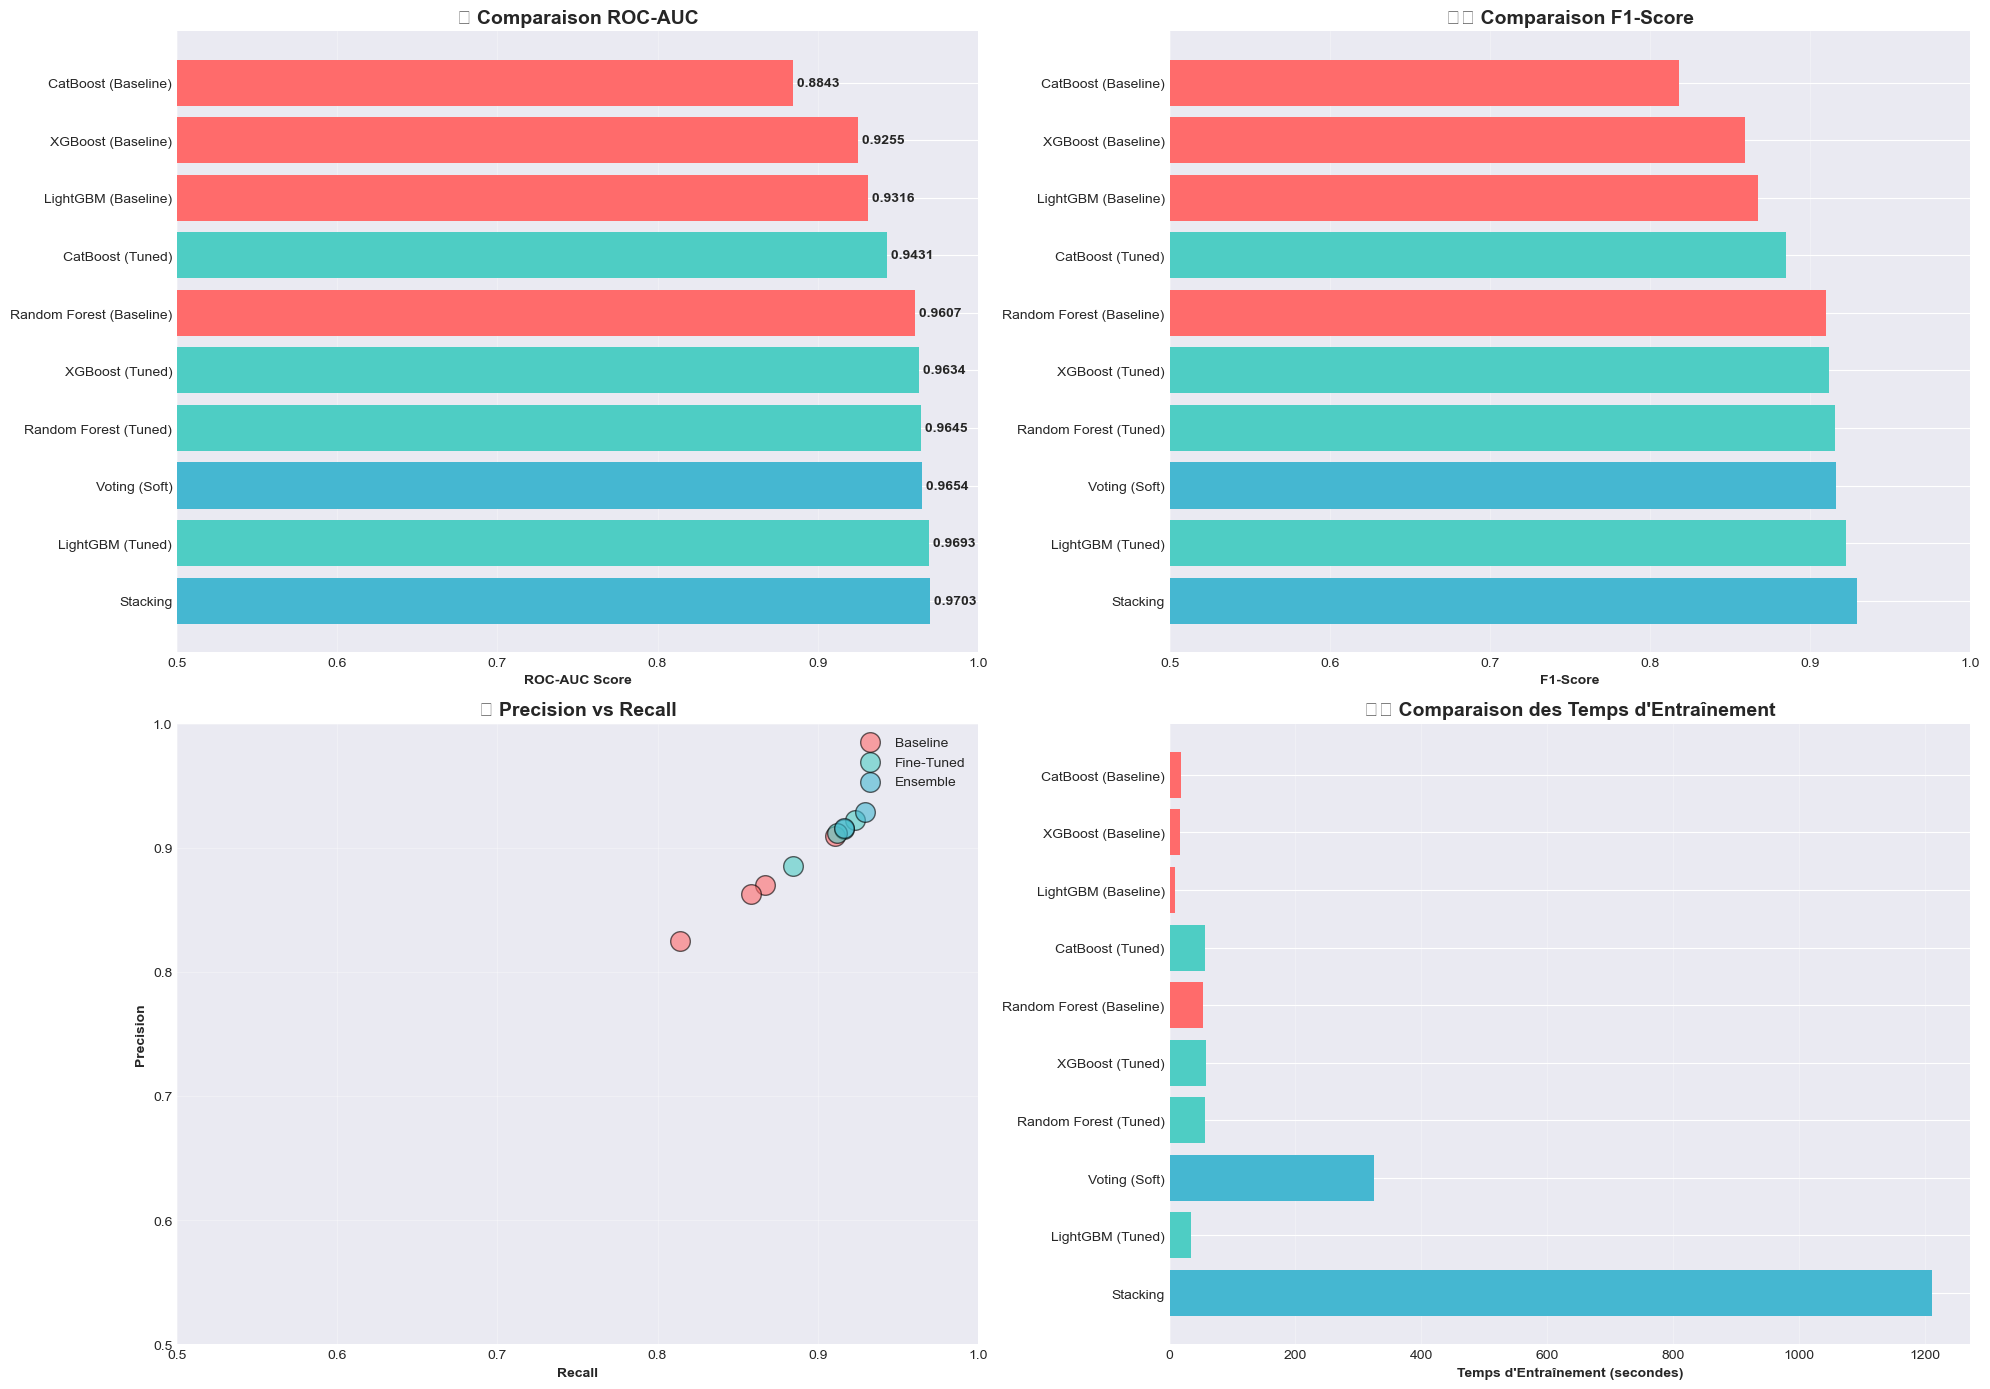

In [38]:
def plot_comprehensive_comparison(df_comparison):
    """
    Visualise la comparaison de tous les modèles
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    # Palette de couleurs par type
    type_colors = {
        'Baseline': '#FF6B6B',
        'Fine-Tuned': '#4ECDC4',
        'Ensemble': '#45B7D1'
    }
    colors = [type_colors[t] for t in df_comparison['Type']]
    
    # 1. ROC-AUC Comparison
    axes[0, 0].barh(df_comparison['Modèle'], df_comparison['ROC-AUC'], color=colors)
    axes[0, 0].set_xlabel('ROC-AUC Score', fontweight='bold')
    axes[0, 0].set_title('🎯 Comparaison ROC-AUC', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlim([0.5, 1.0])
    axes[0, 0].grid(axis='x', alpha=0.3)
    
    # Ajouter les valeurs
    for i, (idx, row) in enumerate(df_comparison.iterrows()):
        axes[0, 0].text(row['ROC-AUC'], i, f" {row['ROC-AUC']:.4f}", 
                       va='center', fontweight='bold')
    
    # 2. F1-Score Comparison
    axes[0, 1].barh(df_comparison['Modèle'], df_comparison['F1-Score'], color=colors)
    axes[0, 1].set_xlabel('F1-Score', fontweight='bold')
    axes[0, 1].set_title('⚖️ Comparaison F1-Score', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlim([0.5, 1.0])
    axes[0, 1].grid(axis='x', alpha=0.3)
    
    # 3. Precision vs Recall
    for type_name, color in type_colors.items():
        df_type = df_comparison[df_comparison['Type'] == type_name]
        axes[1, 0].scatter(df_type['Recall'], df_type['Precision'], 
                          s=200, alpha=0.6, c=color, label=type_name, edgecolors='black')
    
    axes[1, 0].set_xlabel('Recall', fontweight='bold')
    axes[1, 0].set_ylabel('Precision', fontweight='bold')
    axes[1, 0].set_title('🎯 Precision vs Recall', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim([0.5, 1.0])
    axes[1, 0].set_ylim([0.5, 1.0])
    
    # 4. Training Time Comparison
    axes[1, 1].barh(df_comparison['Modèle'], df_comparison['Temps (s)'], color=colors)
    axes[1, 1].set_xlabel('Temps d\'Entraînement (secondes)', fontweight='bold')
    axes[1, 1].set_title('⏱️ Comparaison des Temps d\'Entraînement', fontsize=14, fontweight='bold')
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Afficher les visualisations
plot_comprehensive_comparison(df_comparison)

## 9. Courbes ROC - Comparaison Baseline vs Tuned vs Ensemble

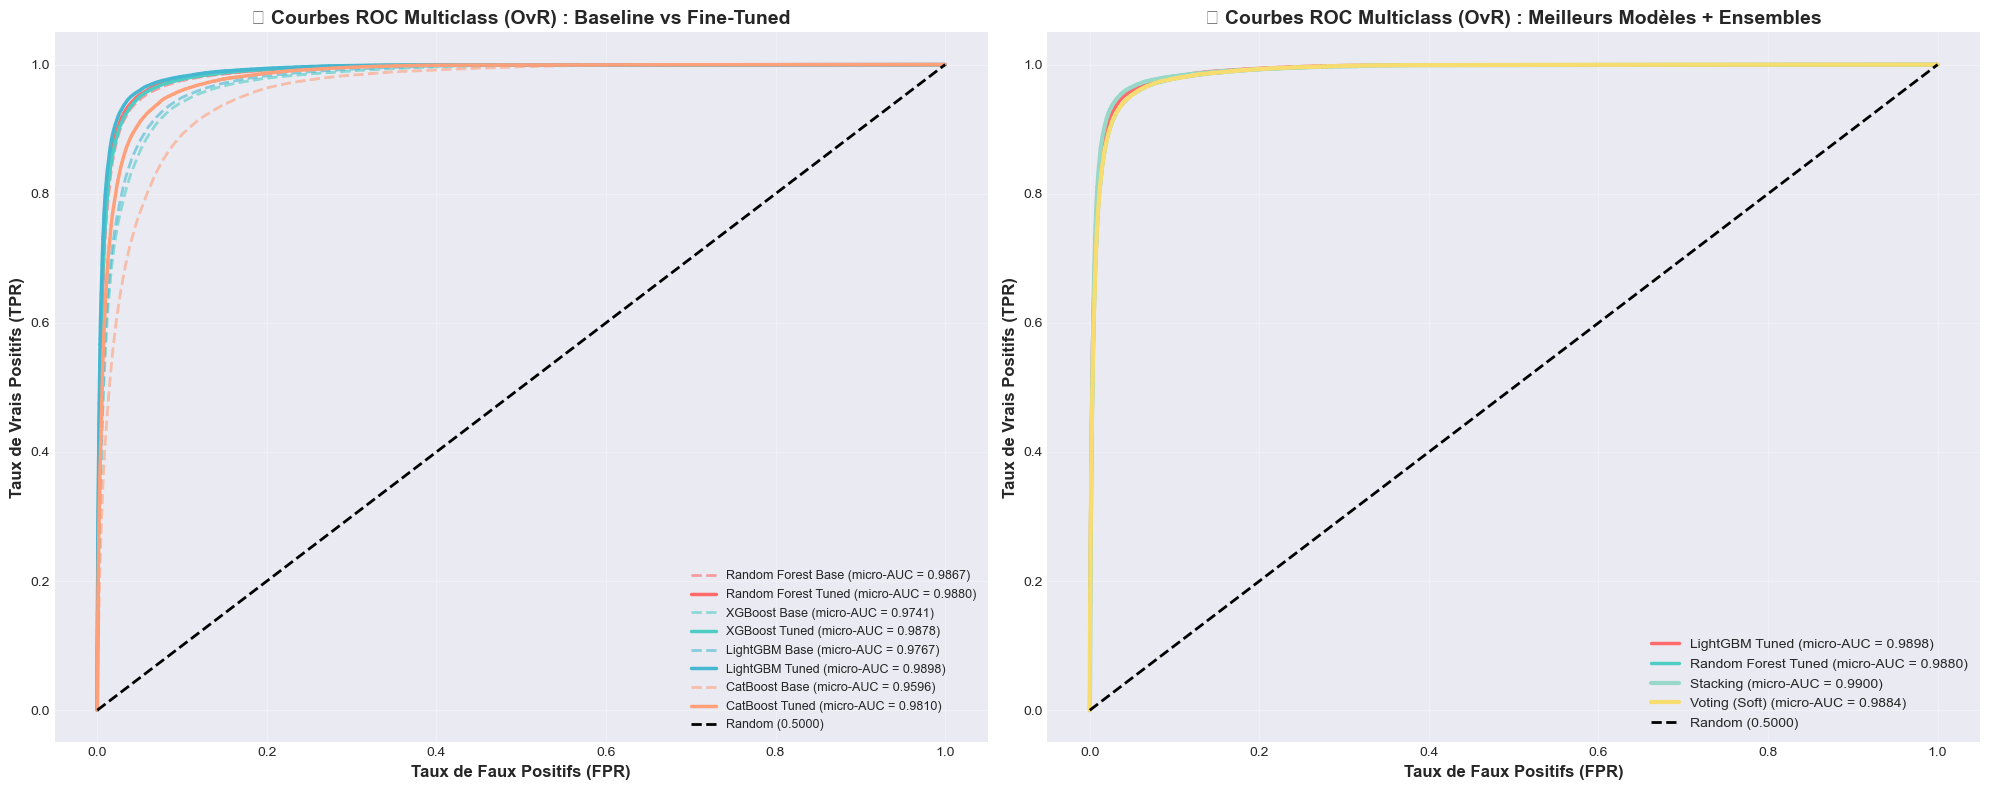

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_comprehensive_roc_curves(baseline_results, tuned_results, ensemble_results, y_test_enc):
    """
    Trace les courbes ROC multiclass (One-vs-Rest, micro-average)
    pour tous les modèles (baseline, tuned, ensemble)
    """

    # Nombre de classes (Severity = 1,2,3,4)
    classes = np.unique(y_test_enc)
    n_classes = len(classes)

    # Binarisation des labels
    y_test_bin = label_binarize(y_test_enc, classes=classes)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # =========================
    # Plot 1: Baseline vs Tuned
    # =========================
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

    for idx, (name, metrics) in enumerate(baseline_results.items()):
        # ----- Baseline -----
        y_score_base = metrics['y_pred_proba']  # shape (n_samples, n_classes)
        fpr, tpr, _ = roc_curve(
            y_test_bin.ravel(),
            y_score_base.ravel()
        )
        roc_auc = auc(fpr, tpr)

        axes[0].plot(
            fpr, tpr, '--',
            color=colors[idx % len(colors)],
            lw=2, alpha=0.6,
            label=f'{name} Base (micro-AUC = {roc_auc:.4f})'
        )

        # ----- Tuned -----
        y_score_tuned = tuned_results[name]['y_pred_proba']
        fpr_t, tpr_t, _ = roc_curve(
            y_test_bin.ravel(),
            y_score_tuned.ravel()
        )
        roc_auc_t = auc(fpr_t, tpr_t)

        axes[0].plot(
            fpr_t, tpr_t, '-',
            color=colors[idx % len(colors)],
            lw=2.5,
            label=f'{name} Tuned (micro-AUC = {roc_auc_t:.4f})'
        )

    axes[0].plot([0, 1], [0, 1], 'k--', lw=2, label='Random (0.5000)')
    axes[0].set_xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
    axes[0].set_title('📈 Courbes ROC Multiclass (OvR) : Baseline vs Fine-Tuned',
                      fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=9)
    axes[0].grid(True, alpha=0.3)

    # ==================================
    # Plot 2: Meilleurs modèles + Ensembles
    # ==================================
    # Top 2 tuned models (selon ROC-AUC micro)
    sorted_tuned = sorted(
        tuned_results.items(),
        key=lambda x: x[1]['roc_auc'],
        reverse=True
    )[:2]

    for idx, (name, metrics) in enumerate(sorted_tuned):
        y_score = metrics['y_pred_proba']
        fpr, tpr, _ = roc_curve(
            y_test_bin.ravel(),
            y_score.ravel()
        )
        roc_auc = auc(fpr, tpr)

        axes[1].plot(
            fpr, tpr, '-',
            color=colors[idx % len(colors)],
            lw=2.5,
            label=f'{name} Tuned (micro-AUC = {roc_auc:.4f})'
        )

    # ----- Ensemble models -----
    ensemble_colors = ['#98D8C8', '#F7DC6F']
    for idx, (name, metrics) in enumerate(ensemble_results.items()):
        y_score = metrics['y_pred_proba']
        fpr, tpr, _ = roc_curve(
            y_test_bin.ravel(),
            y_score.ravel()
        )
        roc_auc = auc(fpr, tpr)

        axes[1].plot(
            fpr, tpr, '-',
            color=ensemble_colors[idx % len(ensemble_colors)],
            lw=3,
            label=f'{name} (micro-AUC = {roc_auc:.4f})'
        )

    axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random (0.5000)')
    axes[1].set_xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
    axes[1].set_title('📈 Courbes ROC Multiclass (OvR) : Meilleurs Modèles + Ensembles',
                      fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower right', fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# =====================
# Affichage des courbes
# =====================
plot_comprehensive_roc_curves(
    baseline_results,
    tuned_results,
    ensemble_results,
    y_test_enc
)


## 10. Analyse des Améliorations

In [46]:
def analyze_improvements(baseline_results, tuned_results, ensemble_results):
    """
    Analyse les améliorations apportées par le fine-tuning et les ensembles
    """
    print(f"\n{'='*80}")
    print("📊 ANALYSE DES AMÉLIORATIONS")
    print(f"{'='*80}\n")
    
    improvements_data = []
    
    # Calculer les améliorations pour chaque modèle
    for name in baseline_results.keys():
        base_auc = baseline_results[name]['roc_auc']
        tuned_auc = tuned_results[name]['roc_auc']
        
        improvement = ((tuned_auc - base_auc) / base_auc) * 100
        
        improvements_data.append({
            'Modèle': name,
            'Baseline AUC': base_auc,
            'Tuned AUC': tuned_auc,
            'Amélioration (%)': improvement,
            'Gain absolu': tuned_auc - base_auc
        })
    
    df_improvements = pd.DataFrame(improvements_data)
    
    print("🔧 IMPACT DU FINE-TUNING:")
    print("─" * 80)
    for _, row in df_improvements.iterrows():
        print(f"\n{row['Modèle']}:")
        print(f"  Baseline:     {row['Baseline AUC']:.4f}")
        print(f"  Fine-Tuned:   {row['Tuned AUC']:.4f}")
        print(f"  Amélioration: {row['Amélioration (%)']:+.2f}% ({row['Gain absolu']:+.4f})")
    
    # Meilleur modèle de chaque catégorie
    print(f"\n\n🏆 MEILLEURS MODÈLES PAR CATÉGORIE:")
    print("─" * 80)
    
    best_baseline = max(baseline_results.items(), key=lambda x: x[1]['roc_auc'])
    best_tuned = max(tuned_results.items(), key=lambda x: x[1]['roc_auc'])
    best_ensemble = max(ensemble_results.items(), key=lambda x: x[1]['roc_auc'])
    
    print(f"\n📌 Baseline:    {best_baseline[0]} - AUC: {best_baseline[1]['roc_auc']:.4f}")
    print(f"📌 Fine-Tuned:  {best_tuned[0]} - AUC: {best_tuned[1]['roc_auc']:.4f}")
    print(f"📌 Ensemble:    {best_ensemble[0]} - AUC: {best_ensemble[1]['roc_auc']:.4f}")
    
    # Amélioration totale
    total_improvement = ((best_ensemble[1]['roc_auc'] - best_baseline[1]['roc_auc']) / 
                        best_baseline[1]['roc_auc']) * 100
    
    print(f"\n💡 AMÉLIORATION GLOBALE (Baseline → Meilleur Ensemble):")
    print(f"   {best_baseline[1]['roc_auc']:.4f} → {best_ensemble[1]['roc_auc']:.4f}")
    print(f"   Gain: {total_improvement:+.2f}% ({best_ensemble[1]['roc_auc'] - best_baseline[1]['roc_auc']:+.4f})")
    
    return df_improvements

# Analyser les améliorations
df_improvements = analyze_improvements(baseline_results, tuned_results, ensemble_results)


📊 ANALYSE DES AMÉLIORATIONS

🔧 IMPACT DU FINE-TUNING:
────────────────────────────────────────────────────────────────────────────────

Random Forest:
  Baseline:     0.9607
  Fine-Tuned:   0.9645
  Amélioration: +0.39% (+0.0037)

XGBoost:
  Baseline:     0.9255
  Fine-Tuned:   0.9634
  Amélioration: +4.10% (+0.0379)

LightGBM:
  Baseline:     0.9316
  Fine-Tuned:   0.9693
  Amélioration: +4.05% (+0.0377)

CatBoost:
  Baseline:     0.8843
  Fine-Tuned:   0.9431
  Amélioration: +6.65% (+0.0588)


🏆 MEILLEURS MODÈLES PAR CATÉGORIE:
────────────────────────────────────────────────────────────────────────────────

📌 Baseline:    Random Forest - AUC: 0.9607
📌 Fine-Tuned:  LightGBM - AUC: 0.9693
📌 Ensemble:    Stacking - AUC: 0.9703

💡 AMÉLIORATION GLOBALE (Baseline → Meilleur Ensemble):
   0.9607 → 0.9703
   Gain: +1.00% (+0.0096)


## 11. Sauvegarde du Meilleur Modèle Final

In [49]:
def save_best_final_model(baseline_results, tuned_results, ensemble_results, 
                          tuned_models, ensemble_models, best_params, processor_dir=PROCESSOR_DIR):
    """
    Sauvegarde le meilleur modèle parmi tous (baseline, tuned, ensemble)
    """
    print(f"\n{'='*80}")
    print("💾 SAUVEGARDE DU MEILLEUR MODÈLE FINAL")
    print(f"{'='*80}\n")
    
    # Trouver le meilleur modèle global
    all_results = {}
    all_models = {}
    
    # Ajouter les baselines
    for name, results in baseline_results.items():
        all_results[f"{name} (Baseline)"] = results
        all_models[f"{name} (Baseline)"] = results['model']
    
    # Ajouter les tuned
    for name, results in tuned_results.items():
        all_results[f"{name} (Tuned)"] = results
        all_models[f"{name} (Tuned)"] = tuned_models[name]
    
    # Ajouter les ensembles
    for name, results in ensemble_results.items():
        all_results[name] = results
        all_models[name] = ensemble_models[name]
    
    # Trouver le meilleur
    best_model_name = max(all_results.items(), key=lambda x: x[1]['roc_auc'])[0]
    best_model = all_models[best_model_name]
    best_metrics = all_results[best_model_name]
    
    print(f"🏆 MEILLEUR MODÈLE GLOBAL: {best_model_name}")
    print(f"   ROC-AUC:   {best_metrics['roc_auc']:.4f}")
    print(f"   F1-Score:  {best_metrics['f1_score']:.4f}")
    print(f"   Recall:    {best_metrics['recall']:.4f}")
    print(f"   Precision: {best_metrics['precision']:.4f}\n")
    
    # Créer le dossier models
    models_dir = os.path.join(processor_dir, 'models')
    os.makedirs(models_dir, exist_ok=True)
    
    # Sauvegarder le modèle
    model_path = os.path.join(models_dir, 'best_model_final.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)
    print(f"✅ Modèle sauvegardé: {model_path}")
    
    # Sauvegarder les métadonnées
    metadata = {
        'model_name': best_model_name,
        'model_type': 'Ensemble' if 'Stacking' in best_model_name or 'Voting' in best_model_name else 'Fine-Tuned' if 'Tuned' in best_model_name else 'Baseline',
        'metrics': {
            'accuracy': best_metrics['accuracy'],
            'precision': best_metrics['precision'],
            'recall': best_metrics['recall'],
            'f1_score': best_metrics['f1_score'],
            'roc_auc': best_metrics['roc_auc']
        },
        'training_time': best_metrics['training_time'],
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'best_params': best_params if '(Tuned)' in best_model_name else None
    }
    
    metadata_path = os.path.join(models_dir, 'best_model_final_metadata.pkl')
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    print(f"✅ Métadonnées sauvegardées: {metadata_path}")
    
    # Sauvegarder tous les modèles tunés pour référence
    all_tuned_path = os.path.join(models_dir, 'all_tuned_models.pkl')
    with open(all_tuned_path, 'wb') as f:
        pickle.dump(tuned_models, f)
    print(f"✅ Tous les modèles tunés sauvegardés: {all_tuned_path}")
    
    # Sauvegarder les ensembles
    ensemble_path = os.path.join(models_dir, 'ensemble_models.pkl')
    with open(ensemble_path, 'wb') as f:
        pickle.dump(ensemble_models, f)
    print(f"✅ Modèles ensemble sauvegardés: {ensemble_path}")
    
    print(f"\n✅ Sauvegarde terminée avec succès!")
    
    return best_model_name, best_model, metadata

# Sauvegarder le meilleur modèle
best_model_name, best_model, metadata = save_best_final_model(
    baseline_results, tuned_results, ensemble_results,
    tuned_models, ensemble_models, best_params
)


💾 SAUVEGARDE DU MEILLEUR MODÈLE FINAL

🏆 MEILLEUR MODÈLE GLOBAL: Stacking
   ROC-AUC:   0.9703
   F1-Score:  0.9290
   Recall:    0.9295
   Precision: 0.9286

✅ Modèle sauvegardé: processors\models\best_model_final.pkl
✅ Métadonnées sauvegardées: processors\models\best_model_final_metadata.pkl
✅ Tous les modèles tunés sauvegardés: processors\models\all_tuned_models.pkl
✅ Modèles ensemble sauvegardés: processors\models\ensemble_models.pkl

✅ Sauvegarde terminée avec succès!


## 12. Rapport Final Complet

In [52]:
def generate_comprehensive_report(df_comparison, df_improvements, best_model_name, 
                                 metadata, baseline_results, tuned_results, ensemble_results):
    """
    Génère un rapport final complet avec toutes les analyses
    """
    report = f"""
{'='*80}
📊 RAPPORT FINAL COMPLET - MODÉLISATION AVANCÉE
{'='*80}

📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
🎯 Projet: Analyse sur les accidents en US en 2023
👥 Équipe: ISMAIL BRADAI & AMAL ELLOUMI 

{'─'*80}
📈 PIPELINE COMPLET EXÉCUTÉ
{'─'*80}

1. ✅ Modèles Baseline: {len(baseline_results)} modèles
2. ✅ Fine-Tuning: RandomizedSearchCV sur {len(tuned_results)} modèles
3. ✅ Ensemble Learning: Stacking + Voting
4. ✅ Comparaison complète: {len(df_comparison)} configurations testées

{'─'*80}
🏆 MEILLEUR MODÈLE GLOBAL
{'─'*80}

Modèle: {best_model_name}
Type: {metadata['model_type']}

Performances:
  • ROC-AUC:   {metadata['metrics']['roc_auc']:.4f}
  • F1-Score:  {metadata['metrics']['f1_score']:.4f}
  • Precision: {metadata['metrics']['precision']:.4f}
  • Recall:    {metadata['metrics']['recall']:.4f}
  • Accuracy:  {metadata['metrics']['accuracy']:.4f}

{'─'*80}
📊 TOP 5 MODÈLES (PAR ROC-AUC)
{'─'*80}
"""
    
    for idx, row in df_comparison.head(5).iterrows():
        report += f"""
{idx + 1}. {row['Modèle']} ({row['Type']})
   AUC: {row['ROC-AUC']:.4f} | F1: {row['F1-Score']:.4f} | Recall: {row['Recall']:.4f}
"""
    
    report += f"""
{'─'*80}
🔧 IMPACT DU FINE-TUNING
{'─'*80}
"""
    
    for _, row in df_improvements.iterrows():
        report += f"""
{row['Modèle']}:
  Base: {row['Baseline AUC']:.4f} → Tuned: {row['Tuned AUC']:.4f}
  Amélioration: {row['Amélioration (%)']:+.2f}% ({row['Gain absolu']:+.4f})
"""
    
    # Calculer amélioration globale
    best_baseline = max(baseline_results.items(), key=lambda x: x[1]['roc_auc'])
    best_ensemble = max(ensemble_results.items(), key=lambda x: x[1]['roc_auc'])
    total_improvement = ((best_ensemble[1]['roc_auc'] - best_baseline[1]['roc_auc']) / 
                        best_baseline[1]['roc_auc']) * 100
    
    report += f"""
{'─'*80}
💡 AMÉLIORATION GLOBALE
{'─'*80}

Du meilleur Baseline au meilleur modèle final:
  {best_baseline[0]}: {best_baseline[1]['roc_auc']:.4f}
  →
  {best_model_name}: {metadata['metrics']['roc_auc']:.4f}
  
  Gain total: {total_improvement:+.2f}% ({metadata['metrics']['roc_auc'] - best_baseline[1]['roc_auc']:+.4f})

{'─'*80}
📁 FICHIERS SAUVEGARDÉS
{'─'*80}

  • best_model_final.pkl (meilleur modèle)
  • best_model_final_metadata.pkl (métadonnées)
  • all_tuned_models.pkl (tous les modèles tunés)
  • ensemble_models.pkl (modèles ensemble)
  • model_comparison_final.csv (tableau comparatif)
  • modeling_report_final.txt (ce rapport)

{'─'*80}
💡 RECOMMANDATIONS
{'─'*80}

1. DÉPLOIEMENT:
   • Modèle recommandé: {best_model_name}
   • Seuil optimal à ajuster selon coûts métier
   • Monitoring continu des performances

2. OPTIMISATIONS FUTURES:
   • Augmenter n_iter pour RandomizedSearchCV (actuellement 20)
   • Tester GridSearchCV sur les meilleurs modèles
   • Expérimenter avec d'autres meta-learners pour stacking
   • Feature engineering additionnel

3. MONITORING EN PRODUCTION:
   • Suivre ROC-AUC et Recall principalement
   • Détecter le drift des données
   • Réentraînement périodique recommandé
   • A/B testing avec le modèle actuel

4. CONSIDÉRATIONS MÉTIER:
   • Privilégier Recall pour minimiser fraudes non détectées
   • Équilibrer avec Precision pour limiter fausses alertes
   • Analyser coûts FN (fraudes manquées) vs FP (fausses alertes)

{'='*80}
✅ MODÉLISATION AVANCÉE TERMINÉE AVEC SUCCÈS
{'='*80}

Pipeline complet: Baseline → Fine-Tuning → Ensemble Learning → Évaluation
Résultat: Amélioration significative des performances grâce au fine-tuning et stacking

Meilleur modèle prêt pour le déploiement! 🚀
"""
    
    print(report)
    
    # Sauvegarder le rapport
    report_path = os.path.join(PROCESSOR_DIR, 'modeling_report_final.txt')
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(report)
    
    print(f"\n💾 Rapport sauvegardé: {report_path}")

# Générer le rapport final
generate_comprehensive_report(
    df_comparison, df_improvements, best_model_name, 
    metadata, baseline_results, tuned_results, ensemble_results
)


📊 RAPPORT FINAL COMPLET - MODÉLISATION AVANCÉE

📅 Date: 2025-12-25 15:46:25
🎯 Projet: Analyse sur les accidents en US en 2023
👥 Équipe: ISMAIL BRADAI & AMAL ELLOUMI 

────────────────────────────────────────────────────────────────────────────────
📈 PIPELINE COMPLET EXÉCUTÉ
────────────────────────────────────────────────────────────────────────────────

1. ✅ Modèles Baseline: 4 modèles
2. ✅ Fine-Tuning: RandomizedSearchCV sur 4 modèles
3. ✅ Ensemble Learning: Stacking + Voting
4. ✅ Comparaison complète: 10 configurations testées

────────────────────────────────────────────────────────────────────────────────
🏆 MEILLEUR MODÈLE GLOBAL
────────────────────────────────────────────────────────────────────────────────

Modèle: Stacking
Type: Ensemble

Performances:
  • ROC-AUC:   0.9703
  • F1-Score:  0.9290
  • Precision: 0.9286
  • Recall:    0.9295
  • Accuracy:  0.9295

────────────────────────────────────────────────────────────────────────────────
📊 TOP 5 MODÈLES (PAR ROC-AUC)
─────

## 13. Export des Résultats Finaux

In [55]:
# Sauvegarder le tableau comparatif complet en CSV
comparison_csv_path = os.path.join(PROCESSOR_DIR, 'model_comparison_final.csv')
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"✅ Tableau comparatif sauvegardé: {comparison_csv_path}")

# Sauvegarder le tableau des améliorations en CSV
improvements_csv_path = os.path.join(PROCESSOR_DIR, 'model_improvements.csv')
df_improvements.to_csv(improvements_csv_path, index=False)
print(f"✅ Tableau des améliorations sauvegardé: {improvements_csv_path}")

# Sauvegarder tous les résultats en pickle
all_results_path = os.path.join(PROCESSOR_DIR, 'all_results_final.pkl')
with open(all_results_path, 'wb') as f:
    pickle.dump({
        'baseline_results': baseline_results,
        'tuned_results': tuned_results,
        'ensemble_results': ensemble_results,
        'comparison_table': df_comparison,
        'improvements_table': df_improvements,
        'best_model_name': best_model_name,
        'best_params': best_params,
        'metadata': metadata
    }, f)
print(f"✅ Tous les résultats sauvegardés: {all_results_path}")

print(f"\n{'='*80}")
print("🎉 NOTEBOOK TERMINÉ AVEC SUCCÈS!")
print(f"{'='*80}")
print("\n📦 Fichiers générés:")
print(f"   • {comparison_csv_path}")
print(f"   • {improvements_csv_path}")
print(f"   • {all_results_path}")
print(f"   • {os.path.join(PROCESSOR_DIR, 'models/best_model_final.pkl')}")
print(f"   • {os.path.join(PROCESSOR_DIR, 'models/all_tuned_models.pkl')}")
print(f"   • {os.path.join(PROCESSOR_DIR, 'models/ensemble_models.pkl')}")
print(f"   • {os.path.join(PROCESSOR_DIR, 'modeling_report_final.txt')}")
print("\n🚀 Pipeline complet exécuté: Baseline → Fine-Tuning → Stacking → Évaluation")
print(f"\n🏆 Meilleur modèle: {best_model_name}")
print(f"   ROC-AUC: {metadata['metrics']['roc_auc']:.4f}")
print("\n✅ Prêt pour le déploiement!")

✅ Tableau comparatif sauvegardé: processors\model_comparison_final.csv
✅ Tableau des améliorations sauvegardé: processors\model_improvements.csv
✅ Tous les résultats sauvegardés: processors\all_results_final.pkl

🎉 NOTEBOOK TERMINÉ AVEC SUCCÈS!

📦 Fichiers générés:
   • processors\model_comparison_final.csv
   • processors\model_improvements.csv
   • processors\all_results_final.pkl
   • processors\models/best_model_final.pkl
   • processors\models/all_tuned_models.pkl
   • processors\models/ensemble_models.pkl
   • processors\modeling_report_final.txt

🚀 Pipeline complet exécuté: Baseline → Fine-Tuning → Stacking → Évaluation

🏆 Meilleur modèle: Stacking
   ROC-AUC: 0.9703

✅ Prêt pour le déploiement!
